<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

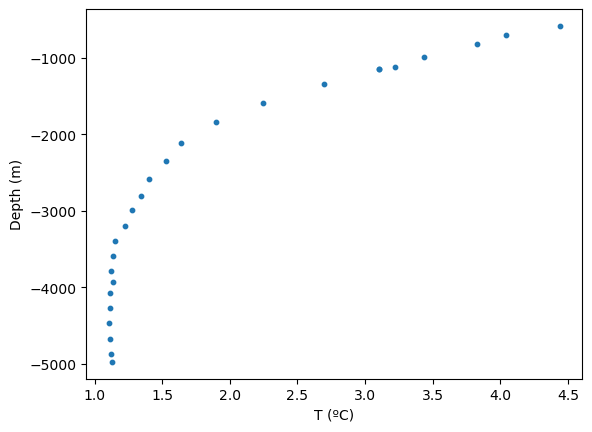

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation. 

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater. 

2025-11-06 09:12:13,374 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


<>:64: SyntaxWarning: invalid escape sequence '\k'
<>:64: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_24461/3822082433.py:64: SyntaxWarning: invalid escape sequence '\k'
  plt.legend(title="$\kappa$ ($m^2/s$)")


2025-11-06 09:12:13,549 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2025-11-06 09:12:13,604 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2025-11-06 09:12:13,658 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2025-11-06 09:12:13,712 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2025-11-06 09:12:13,766 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2025-11-06 09:12:13,821 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2025-11-06 09:12:13,874 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2025-11-06 09:12:13,931 subsystems 0/1 INFO :: Building subproblem matrices 

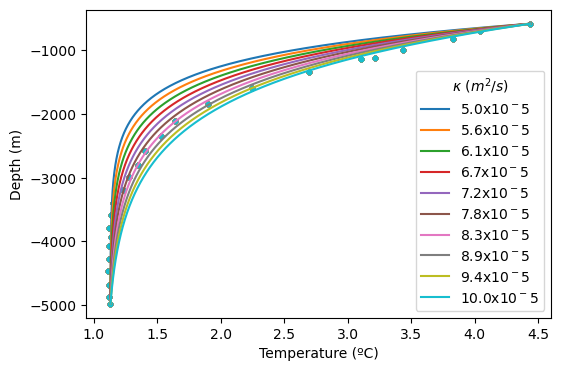

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

plt.figure(figsize=(6, 4))

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappas = [kappa for kappa in np.linspace(5e-5, 10e-5, 10)]

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

for kappa in kappas:
# Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg=T['g']
    plt.scatter(CTD_T,CTD_z,s=10)
    plt.plot(Tg,z, label=f"{kappa*1e5:.1f}x$10^{-5}$")
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Depth (m)')

plt.legend(title="$\kappa$ ($m^2/s$)")

2025-11-06 09:12:14,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s


<>:19: SyntaxWarning: invalid escape sequence '\k'
<>:19: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_24461/2587874249.py:19: SyntaxWarning: invalid escape sequence '\k'
  plt.legend(title="$\kappa$ ($m^2/s$)")


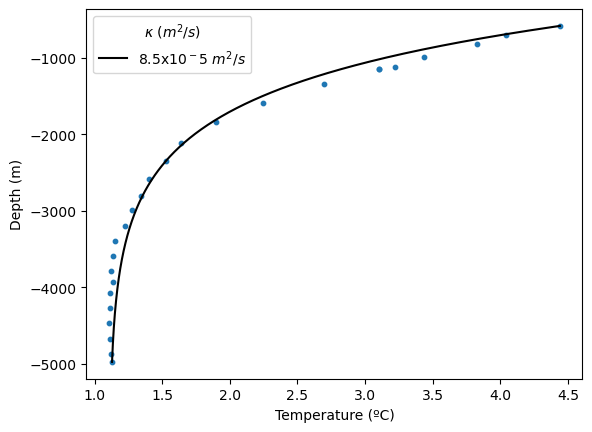

In [4]:
kappa=8.5e-5 # m^2/s

problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k', label=f"{kappa*1e5:.1f}x$10^{-5}$ $m^2/s$")
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

plt.legend(title="$\kappa$ ($m^2/s$)")

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water. 

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data. 

By plugging in different values of $\kappa$, I found that a value of $\sim 8.5 \times 10^{-5} ms^{-2}$ provides a good fit. This value is several orders of magnitude larger than the molecular diffusivity of thermal energy in the ocean, in agreement with Munk's conclusions. This suggests that the advection-diffusion equation cannot represent the data without replacing the diffusivity with an approximate "eddy diffusivity," or by adding an additional term to represent the effects of turbulence. Also, note that in its current state our model still slightly underestimates temperatures at depth and overestimates temperatures towards the surface of the ocean.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$. 

2025-11-06 09:12:15,270 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2025-11-06 09:12:15,340 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2025-11-06 09:12:15,408 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2025-11-06 09:12:15,479 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s
2025-11-06 09:12:15,554 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
2025-11-06 09:12:15,628 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s
2025-11-06 09:12:15,700 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s
2025-11-06 09:12:15,767 subsystems 0/1 INFO :: Building subproblem matrices 

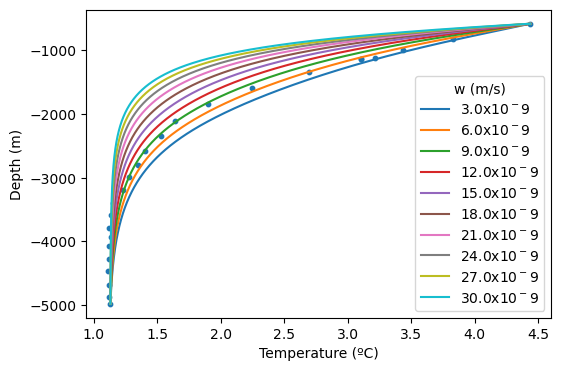

In [5]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

plt.figure(figsize=(6, 4))
plt.scatter(CTD_T,CTD_z,s=10)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
ws = [w for w in np.linspace(3e-9, 3e-8, 10)]

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

for w in ws:
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg=T['g']
    plt.plot(Tg,z, label=f"{w*10**9:.1f}x$10^{-9}$")

plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend(title="w (m/s)")

In [6]:
ws

[np.float64(3e-09),
 np.float64(5.999999999999999e-09),
 np.float64(9e-09),
 np.float64(1.1999999999999998e-08),
 np.float64(1.5e-08),
 np.float64(1.8e-08),
 np.float64(2.0999999999999996e-08),
 np.float64(2.3999999999999997e-08),
 np.float64(2.6999999999999997e-08),
 np.float64(3e-08)]

2025-11-06 09:12:16,388 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s


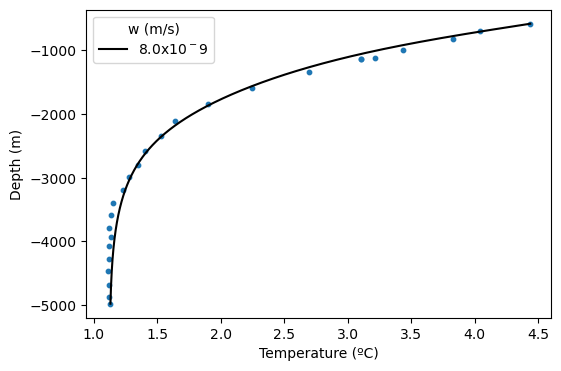

In [7]:
# Problem
w=8e-9

problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
Tg=T['g']

plt.figure(figsize=(6, 4))
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z, "k",label=f"{w*10**9:.1f}x$10^{-9}$")

plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend(title="w (m/s)")

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

When $w=0$, the equation above implies that $\kappa(z) \frac{\partial T}{\partial z} = const.$, meaning $\kappa$ is inversely proportional to the vertical temperature gradient and the diffusive heat flux ($\kappa(z) \frac{\partial T}{\partial z}$) is constant with height. The fact that we get a somewhat resonable fit to the data when $w=0$ implies that the effect of the diffusive heat flux on the vertical temperature profile is much more dominant than the effect of the heat flux due to vertical advection.

$w = 8\times 10^{-9}$ m/s provides a better fit. The following plots and discussion explore what happens to this optimal value for $w$ if we modify the vertical diffusivity profile:

In [8]:
kappa = 1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)
kappa_large_l = 1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/1000)
kappa_k0 = 1e-5 + (3e-4 - 1e-5)*np.exp((-5e3-z)/667)
kappa_poly = (z**4)/7e17
kappas = [kappa_large_l, kappa_k0,kappa_poly]

<>:3: SyntaxWarning: invalid escape sequence '\k'
<>:7: SyntaxWarning: invalid escape sequence '\k'
<>:3: SyntaxWarning: invalid escape sequence '\k'
<>:7: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_24461/3198363458.py:3: SyntaxWarning: invalid escape sequence '\k'
  plt.plot(z, kappa_k0, label = "$\kappa_0 = 3e-4$ ($m^2/s$)")
/tmp/ipykernel_24461/3198363458.py:7: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel("$\kappa$ ($m^2/s$)")


Text(0, 0.5, '$\\kappa$ ($m^2/s$)')

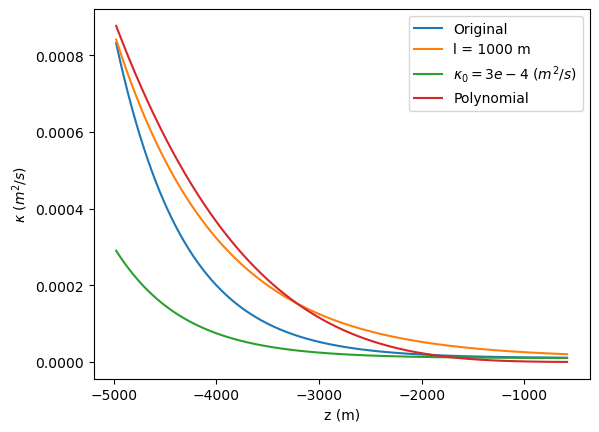

In [9]:
plt.plot(z, kappa, label = "Original")
plt.plot(z, kappa_large_l, label = "l = 1000 m")
plt.plot(z, kappa_k0, label = "$\kappa_0 = 3e-4$ ($m^2/s$)")
plt.plot(z, kappa_poly, label = "Polynomial")
plt.legend()
plt.xlabel("z (m)")
plt.ylabel("$\kappa$ ($m^2/s$)")

<>:13: SyntaxWarning: invalid escape sequence '\k'
<>:13: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_24461/236973601.py:13: SyntaxWarning: invalid escape sequence '\k'
  labels = ["l=1000 m", "$\kappa_0 = 3e-4$ ($m^2/s$)", "Polynomial"]


2025-11-06 09:12:17,007 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s
2025-11-06 09:12:17,049 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2025-11-06 09:12:17,091 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2025-11-06 09:12:17,133 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2025-11-06 09:12:17,174 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2025-11-06 09:12:17,215 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2025-11-06 09:12:17,252 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2025-11-06 09:12:17,288 subsystems 0/1 INFO :: Building subproblem matrices 

Text(0.5, 0, 'Temperature (ºC)')

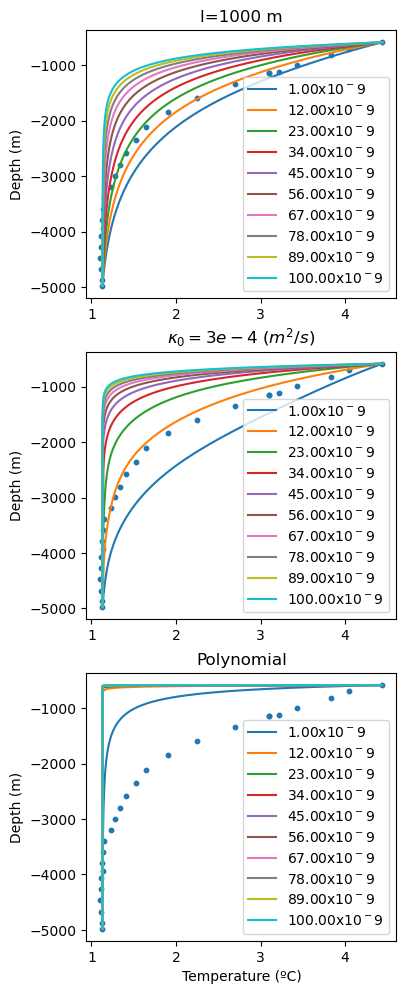

In [10]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

plt.figure(figsize=(4, 16))
labels = ["l=1000 m", "$\kappa_0 = 3e-4$ ($m^2/s$)", "Polynomial"]

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
ws = [w for w in np.linspace(1e-9,1e-7, 10)]

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
#kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s
#kappa['g']=8.6e-4-1e-5 # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

for i, kap in enumerate(kappas):
    kappa = dist.Field(name='kappa', bases=zbasis)
    kappa['g'] = kap

    plt.subplot(4,1,i+1)
    plt.scatter(CTD_T,CTD_z,s=10)
    plt.ylabel('Depth (m)')
    plt.title(labels[i])
    for w in ws:
        # Problem
        problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
        problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
        problem.add_equation("T(z=z_surface) = T_surface")
        problem.add_equation("T(z=z_bottom) = T_bottom")

        # Solver
        solver = problem.build_solver()
        solver.solve()

        # Plot
        Tg=T['g']
        plt.plot(Tg,z,label=f"{w*10**9:.2f}x$10^{-9}$")
    plt.legend()
plt.xlabel('Temperature (ºC)')

2025-11-06 09:12:18,594 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2025-11-06 09:12:18,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s
2025-11-06 09:12:18,659 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
2025-11-06 09:12:18,723 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2025-11-06 09:12:18,773 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2025-11-06 09:12:18,808 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2025-11-06 09:12:18,839 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2025-11-06 09:12:18,869 subsystems 0/1 INFO :: Building subproblem matrices 

Text(0.5, 0, 'Temperature (ºC)')

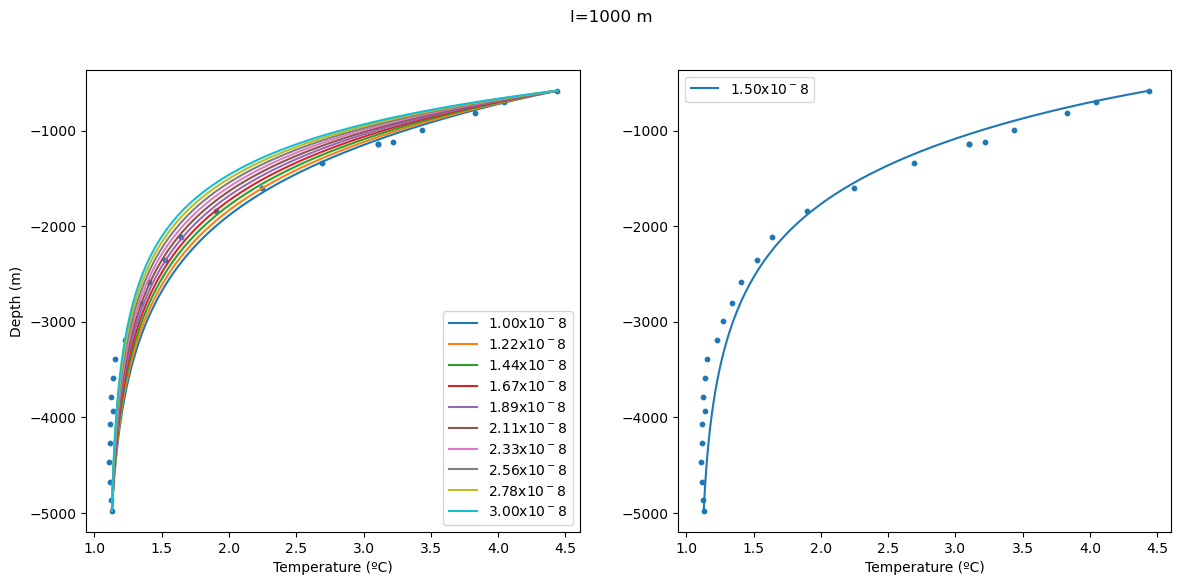

In [11]:
kap = kappas[0]
kappa = dist.Field(name='kappa', bases=zbasis)
kappa['g'] = kap


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(CTD_T,CTD_z,s=10)
plt.ylabel('Depth (m)')
plt.suptitle(labels[0])

ws = [w for w in np.linspace(1e-8,3e-8, 10)]

for w in ws:
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg=T['g']
    plt.plot(Tg,z,label=f"{w*10**8:.2f}x$10^{-8}$")
plt.legend()
plt.xlabel('Temperature (ºC)')


w = 1.5e-8
plt.subplot(1,2,2)
plt.scatter(CTD_T,CTD_z,s=10)
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
Tg=T['g']
plt.plot(Tg,z,label=f"{w*10**8:.2f}x$10^{-8}$")

plt.legend()
plt.xlabel('Temperature (ºC)')

2025-11-06 09:12:19,398 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2025-11-06 09:12:19,434 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2025-11-06 09:12:19,466 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+01/s
2025-11-06 09:12:19,498 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+01/s
2025-11-06 09:12:19,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2025-11-06 09:12:19,586 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2025-11-06 09:12:19,617 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+01/s
2025-11-06 09:12:19,647 subsystems 0/1 INFO :: Building subproblem matrices 

Text(0.5, 0, 'Temperature (ºC)')

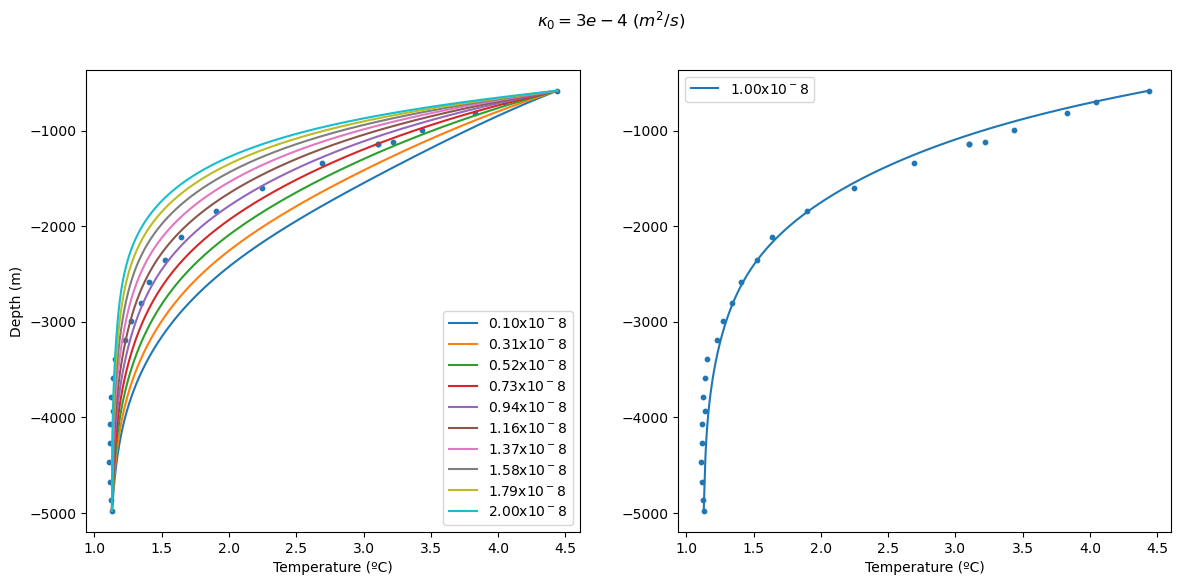

In [12]:
kap = kappas[1]
kappa = dist.Field(name='kappa', bases=zbasis)
kappa['g'] = kap


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(CTD_T,CTD_z,s=10)
plt.ylabel('Depth (m)')
plt.suptitle(labels[1])

ws = [w for w in np.linspace(1e-9,2e-8, 10)]

for w in ws:
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg=T['g']
    plt.plot(Tg,z,label=f"{w*10**8:.2f}x$10^{-8}$")
plt.legend()
plt.xlabel('Temperature (ºC)')


w = 1e-8
plt.subplot(1,2,2)
plt.scatter(CTD_T,CTD_z,s=10)
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
Tg=T['g']
plt.plot(Tg,z,label=f"{w*10**8:.2f}x$10^{-8}$")

plt.legend()
plt.xlabel('Temperature (ºC)')

2025-11-06 09:12:20,113 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2025-11-06 09:12:20,164 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2025-11-06 09:12:20,196 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
2025-11-06 09:12:20,227 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s
2025-11-06 09:12:20,256 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2025-11-06 09:12:20,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2025-11-06 09:12:20,316 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2025-11-06 09:12:20,348 subsystems 0/1 INFO :: Building subproblem matrices 

Text(0.5, 0, 'Temperature (ºC)')

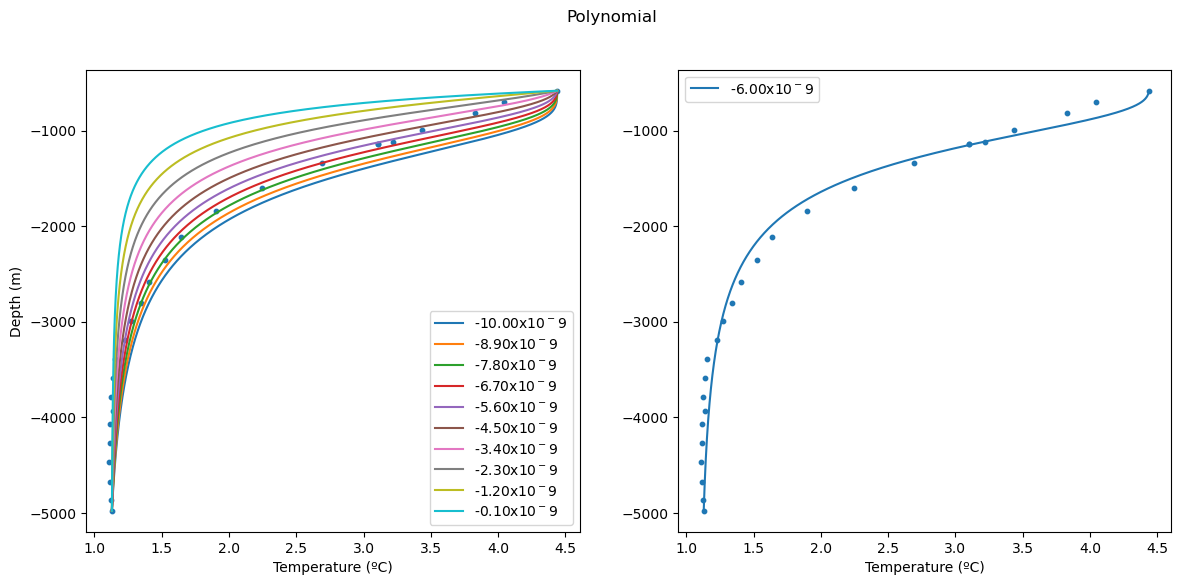

In [13]:
kap = kappas[2]
kappa = dist.Field(name='kappa', bases=zbasis)
kappa['g'] = kap


plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(CTD_T,CTD_z,s=10)
plt.ylabel('Depth (m)')
plt.suptitle(labels[2])

ws = [w for w in np.linspace(-1e-8, -1e-10, 10)]

for w in ws:
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg=T['g']
    plt.plot(Tg,z,label=f"{w*10**9:.2f}x$10^{-9}$")
plt.legend()
plt.xlabel('Temperature (ºC)')


w = -6e-9
plt.subplot(1,2,2)
plt.scatter(CTD_T,CTD_z,s=10)
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
Tg=T['g']
plt.plot(Tg,z,label=f"{w*10**9:.2f}x$10^{-9}$")

plt.legend()
plt.xlabel('Temperature (ºC)')

I explored three different modifications to the diffusivity profile: changing the decay rate to l=1000 m, setting the diffusivity profile to 
$ \kappa(z)=\kappa_{bg} + (3*10^-5 - \kappa_{bg})e^{-(z+D)/l} $ (loosely approximating decreased turbulent diffusivity at the bottom boundary), and using changing the form of the diffusivity profile such that $\kappa(z) = \alpha z^4$, where $\alpha$ is a small constant. For each modification, respectively, I found that the roughly optimal vertical velocities were $1.5$ x $10^{-8}$ m/s, $1$ x $10^{-8}$ m/s, and $-6$ x $10^{-8}$ m/s. 

For the first two cases where I modified the exponential temperature profile we've been given, we see that $w$ is slightly sensitive to these changes, increasing by about 25-85%. The case where l = 1000 m loosely represents increased turbulent diffusivity at depth, suggesting that increased turbulent mixing at the bottom is balanced by increased vertical velocities. The vertical velocity is less sensitive to changes in $\kappa_0$, although we also see that changing the turbulent diffusivity at the bottom boundary does change the behavior of vertical motions in the ocean. 

For case where I replaced the diffusivity profile with an exponential form, we see that the best fit requires negative vertical velocities. This implies that in certain cases where topography or ocean dynamics generate a slightly different diffusivity profile structure, the resulting turbulent processes could be balanced by downwelling. 

These results suggest that varying bottom topography, and thus varying turbulent diffusivities, can drive overturning and inhomogeneous vertical structures in the ocean. As suggested by the l = 1000 m case, regions with rougher bottoms or shallower depths (higher diffusivities at a given depth) may experience increased upwelling, while downwelling may occur elsewhere for certain topographies. Qualitatively, these findings are broadly consistent with Ferrari et al.'s theory that downwelling occurs in interior oceans and upwelling occurs in "thin boundary layers along the sloping sides of ocean basins."

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as 

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [14]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])]; 

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

2025-11-06 09:12:20,918 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+00/s
2025-11-06 09:12:20,920 __main__ 0/1 INFO :: Starting main loop
2025-11-06 09:12:21,337 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2025-11-06 09:12:21,350 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2025-11-06 09:12:21,363 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2025-11-06 09:12:21,376 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2025-11-06 09:12:21,388 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2025-11-06 09:12:21,401 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2025-11-06 09:12:21,413 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2025-11-06 09:12:21,425 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2025-11-06 09:12:21,439 __main__ 0/1 INFO :: Iteratio

## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command: 

`conda install -c conda-forge ffmpeg`

2025-11-06 09:12:22,499 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-11-06 09:12:22,500 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpo41kmrro/temp.m4v


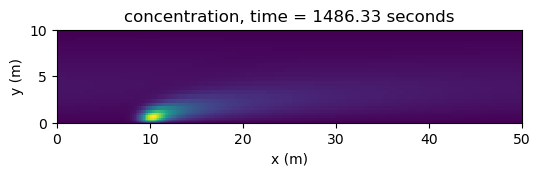

In [15]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

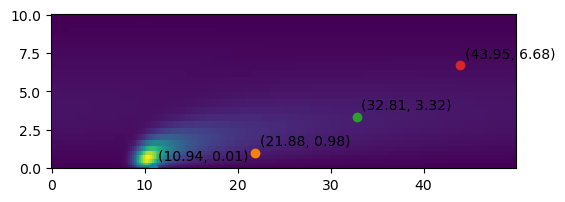

In [16]:
fig = plt.figure(figsize=(6,2))

(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  
plt.pcolor(X, Y, c_save[-1,:,:].T)
points = [[int(11*(i+1)/(50/Nx)), int((i*2)/(10/Ny))] for i in range(0, 4)]

for point in points:
    plt.scatter(x[point[0]], y[0, point[1]])
    plt.text(x[point[0]]+0.5, y[0, point[1]]+0.5,f"({x[point[0]].item():.2f}, {y[0, point[1]].item():.2f})")

Text(0, 0.5, 'Concentration')

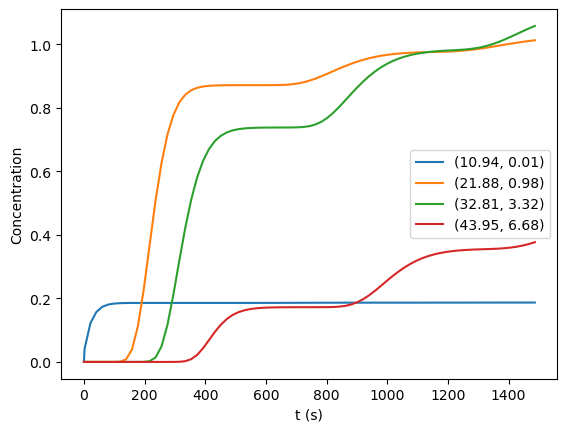

In [17]:
points = [[int(11*(i+1)/(50/Nx)), int((i*2)/(10/Ny))] for i in range(0, 4)]

for point in points:
    plt.plot(t_save, c_save[:, point[0], point[1]], label = f"({x[point[0]].item():.2f}, {y[0, point[1]].item():.2f})")


plt.legend()
plt.xlabel("t (s)")
plt.ylabel("Concentration")

2025-11-06 09:12:31,736 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+00/s
2025-11-06 09:12:31,738 __main__ 0/1 INFO :: Starting main loop
2025-11-06 09:12:31,756 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2025-11-06 09:12:31,769 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2025-11-06 09:12:31,782 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2025-11-06 09:12:31,794 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2025-11-06 09:12:31,806 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2025-11-06 09:12:31,819 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2025-11-06 09:12:31,832 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2025-11-06 09:12:31,844 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2025-11-06 09:12:31,857 __main__ 0/1 INFO :: Iteratio

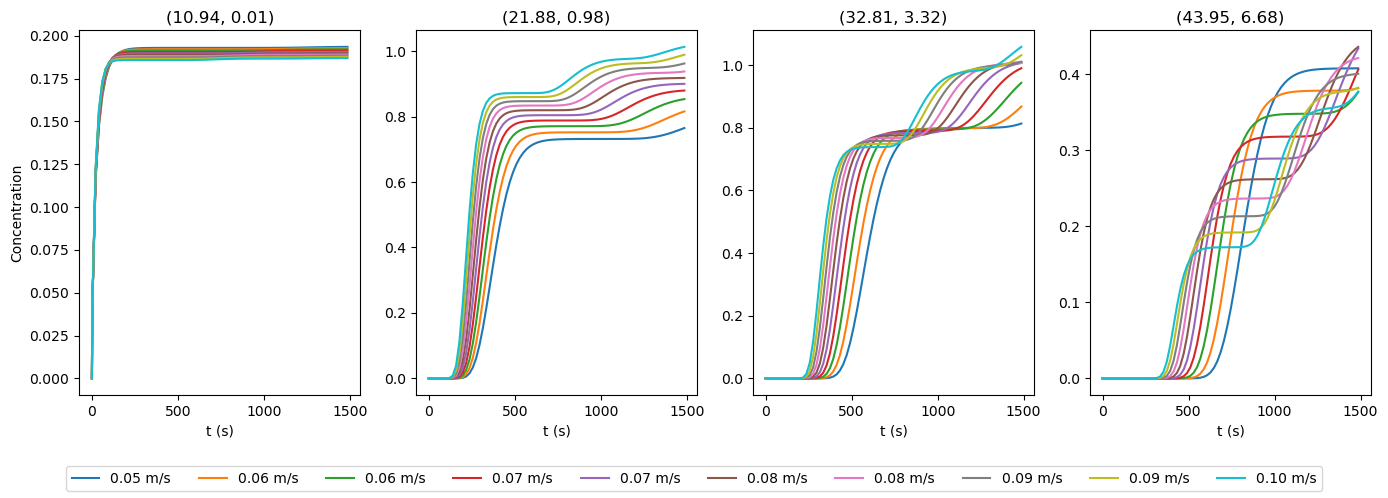

In [18]:
# choose the point nearest (30, 3)
xpoint = int(30/(50/Nx))
ypoint = int(3/(10/Ny))

U0s = [i for i in np.linspace(0.05, 0.1, 10)]
plt.figure(figsize=(14, 5))
lines=[]
labels=[]

for U0 in U0s:
    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]; 

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    for i, point in enumerate(points):
        plt.subplot(1,4,i+1)
        line = plt.plot(t_save, c_save[:, point[0], point[1]])
        plt.xlabel("t (s)")
        if i == 0:
            plt.ylabel("Concentration")
            lines.append(line[0])
            labels.append(f"{U0:.2f} m/s")
        plt.title(f"({x[point[0]].item():.2f}, {y[0, point[1]].item():.2f})")

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for legend at bottom
plt.figlegend(lines, labels, loc='lower center', ncol=10)

2025-11-06 09:12:44,392 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s
2025-11-06 09:12:44,394 __main__ 0/1 INFO :: Starting main loop
2025-11-06 09:12:44,412 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2025-11-06 09:12:44,424 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2025-11-06 09:12:44,436 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2025-11-06 09:12:44,448 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2025-11-06 09:12:44,461 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2025-11-06 09:12:44,473 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2025-11-06 09:12:44,485 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2025-11-06 09:12:44,497 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2025-11-06 09:12:44,509 __main__ 0/1 INFO :: Iteratio

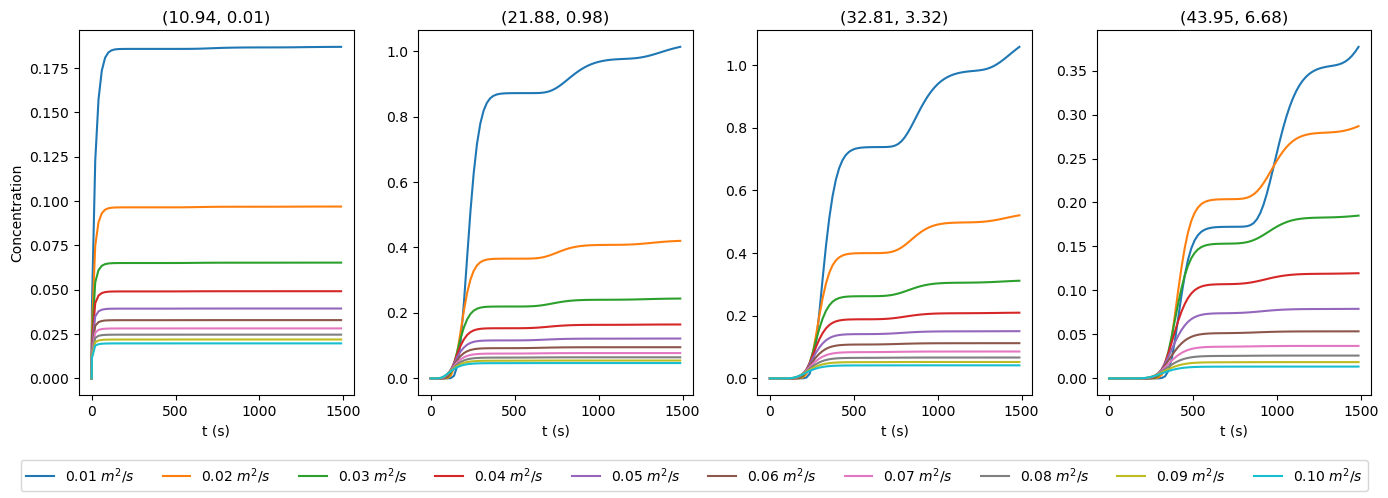

In [19]:
# choose the point nearest (30, 3)
xpoint = int(30/(50/Nx))
ypoint = int(3/(10/Ny))

kappas = np.linspace(0.01, 0.1, 10)
plt.figure(figsize=(14, 5))
lines=[]
labels=[]

for kappa in kappas:
    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]; 

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    for i, point in enumerate(points):
        plt.subplot(1,4,i+1)
        line = plt.plot(t_save, c_save[:, point[0], point[1]])
        plt.xlabel("t (s)")
        if i == 0:
            plt.ylabel("Concentration")
            lines.append(line[0])
            labels.append(f"{kappa:.2f} $m^2/s$")
        plt.title(f"({x[point[0]].item():.2f}, {y[0, point[1]].item():.2f})")

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for legend at bottom
plt.figlegend(lines, labels, loc='lower center', ncol=10)

        

Generally, our simulation shows that tracer from the source is carried downstream over time, arriving at points nearest the source first and with the highest initial concentrations. As time progresses, tracer diffuses through the water and is advected by the current, reaching points downstream in lower concentrations than found near the source term.

We can see that increasing the speed of our river decreases the amount of time it takes for the tracer to reach a given point downstream (but the effect of these changes right next to the source are much less apparent). The long-term concentration of the tracer at a given point also increases with higher speeds, except near the source. This is likely because more tracer per time is being carried away from the source and reaching these points. (Aside: note that the behavior of tracer at (43.5, 6.7) appears to increase in loose "steps," a form we see in many of the curves produced from our simulation - perhaps due to the spectral methods or periodic boundary conditions used in our analysis? The first amount of tracer that reaches this point is lower for higher speeds, but over time, it appears that the concetration will increase in these "steps" and reach some equilibirium.)

On the other hand, we see that when we increase the diffusivity, the long-term concentration of tracer in the river decreases. This occurs because the tracer spreads out within the river more efficiently at higher diffusivities (more homogenous concentration implies less tracer concentrated at a given point). Additionally, we see that the tracer reaches a given point in the river slightly sooner at higher diffusivities, again because the tracer is able to diffuse through the environment more quickly/efficiently at higher diffusivities. 

Scaling: Our model equations specify that advection only occurs in the x-direction. Thus, vertical transport of tracers is only goverened by diffusion, meaning we can find a charateristic timescale as follows: 

$\frac{C}{T} \sim \frac{\kappa C}{Y^2} \implies T \sim \frac{Y^2}{\kappa} = \frac{(10 m)^2}{0.01 m^2/s} = 10000 s$.

Using this timescale, we would expect the tracer to travel a distance downstream on the order of

$U_0 \sim X/T \implies X \sim U_0T = (0.1 m/s)(10000 s) = 1000 m$.

Since the current speed varies with y, however, this is likely an overestimate.

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

In [20]:
"""
Script to solve the time-dependent advection/diffusion equation with turbulence
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

c_saves = []
# wavenumber needs to be of the form 2pi*n/L, where L is the size of the domain we want an integer 
# number (n) of wavelengths to fit in. We take L=10 to ensure this integer number of wavelengths fit in the vertical
# and horizontal extents of our domain.
ks = [(k*np.pi)/10 for k in range(2,11,2)]

# Set parameters
U0 = 0.1 # maximum current speed in m/s
u0 = 0.05 #m/s, amplitude of oscillations
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
#k = 1 # wavenumber

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

for k in ks:
    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    v = dist.Field(name='v', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile
    u['g'] = u['g'] + u0 * np.cos(k*x)*np.cos(k*y)
    v['g'] = u0 * np.sin(k*x)*np.sin(k*y)

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])
    dy = lambda A: dedalus.Differentiate(A, coords['y'])

    S = dist.Field(name='S', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    print("made it")
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]; 

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)
    c_saves.append(c_save)

2025-11-06 09:12:57,336 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
made it
2025-11-06 09:12:57,338 __main__ 0/1 INFO :: Starting main loop
2025-11-06 09:12:57,487 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2025-11-06 09:12:57,548 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2025-11-06 09:12:57,597 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2025-11-06 09:12:57,645 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2025-11-06 09:12:57,693 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2025-11-06 09:12:57,744 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2025-11-06 09:12:57,794 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2025-11-06 09:12:57,846 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2025-11-06 09:12:57,899 __main__ 0/1 INFO :: 

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_24461/366988214.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(t_save, c_save[:, xpoint, ypoint], label = f"k = {int(10*ks[i]/np.pi/2)}$\pi$/5")


Text(0, 0.5, 'Concentration')

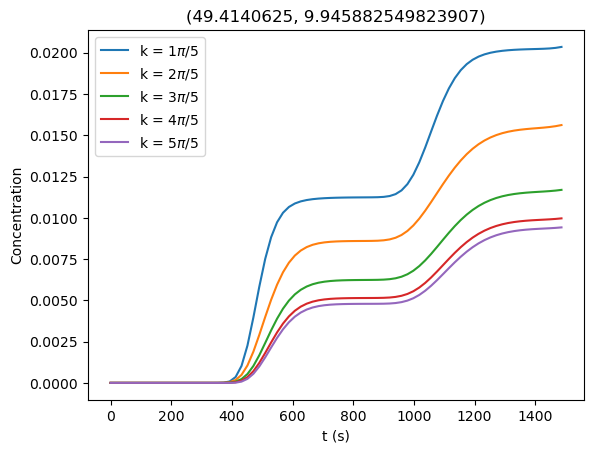

In [21]:
xpoint = int(49.5/(50/Nx))
ypoint = int(9.5/(10/Ny))

for i, c_save in enumerate(c_saves):
    plt.plot(t_save, c_save[:, xpoint, ypoint], label = f"k = {int(10*ks[i]/np.pi/2)}$\pi$/5")

plt.legend()
plt.title(f"{x[xpoint].item(), y[:, ypoint].item()}")
plt.xlabel("t (s)")
plt.ylabel("Concentration")

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_24461/3089194509.py:19: SyntaxWarning: invalid escape sequence '\p'
  plt.title('concentration, k = $\pi$, time = {0:.2f} seconds'.format(t_save[n]))


2025-11-06 09:13:17,141 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-11-06 09:13:17,141 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpln7q7b8t/temp.m4v


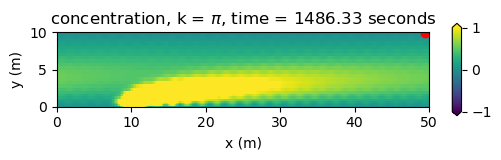

In [22]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_saves[-1][n,:,:].T, vmin=-1, vmax=1)
    plt.colorbar(shrink=0.2, aspect=10, extend="both")
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, k = $\pi$, time = {0:.2f} seconds'.format(t_save[n]))
    plt.scatter(x[xpoint], y[:, ypoint], c="r")
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [23]:
"""
Script to solve the time-dependent advection/diffusion equation with turbulence
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

c_saves = []
t_saves = []
u0s = [i for i in np.linspace(0.05, 0.1, 10)]

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k = 2*np.pi/10 # wavenumber

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

for u0 in u0s:
    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    v = dist.Field(name='v', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile
    u['g'] = u['g'] + u0 * np.cos(k*x)*np.cos(k*y)
    v['g'] = u0 * np.sin(k*x)*np.sin(k*y)

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])
    dy = lambda A: dedalus.Differentiate(A, coords['y'])

    S = dist.Field(name='S', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    print("made it")
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]; 

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)
    c_saves.append(c_save)
    t_saves.append(t_save)

2025-11-06 09:13:27,904 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s
made it
2025-11-06 09:13:27,906 __main__ 0/1 INFO :: Starting main loop
2025-11-06 09:13:28,047 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2025-11-06 09:13:28,129 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2025-11-06 09:13:28,202 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2025-11-06 09:13:28,275 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2025-11-06 09:13:28,353 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2025-11-06 09:13:28,406 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2025-11-06 09:13:28,455 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2025-11-06 09:13:28,516 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2025-11-06 09:13:28,584 __main__ 0/1 INFO :: 

Text(0, 0.5, 'Concentration')

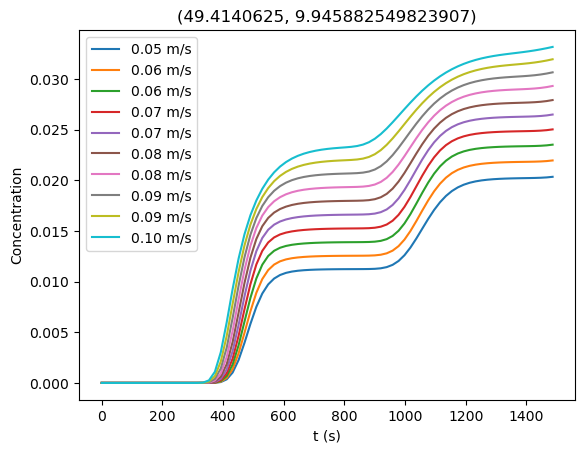

In [24]:
xpoint = int(49.5/(50/Nx))
ypoint = int(9.5/(10/Ny))
for i, c_save in enumerate(c_saves):
    plt.plot(t_saves[0], c_save[:, xpoint, ypoint], label = f"{u0s[i]:.2f} m/s")

plt.legend()
plt.title(f"{x[xpoint].item(), y[:, ypoint].item()}")
plt.xlabel("t (s)")
plt.ylabel("Concentration")

2025-11-06 09:14:13,549 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-11-06 09:14:13,549 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmqrq2xjw/temp.m4v


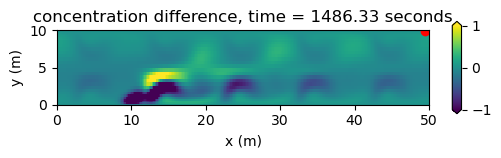

In [25]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_saves[-1][n,:,:].T - c_saves[0][n,:,:].T, vmin=-1, vmax=1)
    plt.colorbar(shrink=0.2, aspect=10, extend="both")
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration difference, time = {0:.2f} seconds'.format(t_save[n]))
    plt.scatter(x[xpoint], y[:, ypoint], c="r")

    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

These results explore the transport of tracer from the source to the other side of the river (here, taken a point across the river downstream from the source, i.e., (49.4, 9.94)). We find that the time it takes for the tracer to reach the other side of the river generally decreases with decreasing wavenumber. Because larger wavenumbers are analagous to smaller eddies, this result suggests that smaller length scale turbulence inhibits transport of tracers across large distances. This is likely because turbulence on smaller scales enhances local mixing, distributing tracer evenly near the source and through the mean flow of the river rather than transporting it across longer distances, as shown in the movie for $k=\pi$.

Meanwhile, increasing $u_0$ decreases the time it takes for tracer to reach the other side of the river for $k=\pi/5$. This is because the amplitude of our velocity field is larger, corresponding to faster-spinning eddies and thus more rapid distribution of tracer via turbulent mixing. A movie showing the difference between $u_0=0.1$ m/s and $u_0=0.05$ m/s confirms that the initial "pulse" of tracer from the source is carried downstream and across the river faster for higher $u_0$ 's.

These results agree with our proposed turbulent diffusivity. We've said that $\kappa_T \sim u*l$, meaning that the diffusivity should increase with increasing eddy velocities and length scales. To recap, our numerical results show that increasing $u_0$ and decreasing $k$ - corresponding to larger-scale eddies - both decrease the amount of time it takes to transport tracer to the other side of the river. This means that faster, larger turbulent eddies the tracer to more quickly "diffuse" through the river over a given period.

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.